# XGBoost

Objective function = Loss function $+$ Regularization Term = $L(\theta)+\Omega(\theta)$ 


The training loss measures how predictive our model is w.r.t. to the training data. 


For $\textbf{Regression}$, the common choice is $\textit{mean squared error}$, which is given by \
$L(\theta)=\sum_{i}(y_{i}-\hat{y}_{i})^2$ 

For $\textbf{Classification}$, we use $\textbf{Logistic Loss}$, given by \
$L(\theta)=\sum_{i}[y_i*ln(1+e^{-\hat{y}_i})+(1-y_i)*ln(1+e^{\hat{y}_i})]$

The regularization term, $\Omega(\theta)$, controls the complexity of the model, which helps us to avoid overfitting.

Mathematically, $\hat{y}_i$ is given by \
$\begin{alignat}{1}\hat{y}_i=\sum_{k=1}^{K}f_{k}(x_i), f_k \in \mathcal{F}\end{alignat}$ \
where, $K$ is the number of trees, $f_k$ is a function in functional space $\mathcal{F}$, and $\mathcal{F}$ is the set of all possible CARTs.

$\implies \hat{y}^{(t)}_i = \hat{y}^{(t-1)}_i+f_t(x_i)$

The objective function for the model, at any time step $t$, is given by \
$\begin{alignat}{1}\textit{obj}^{(t)}&=\sum_{i=1}^nl(y_i,\hat{y}_i^t)+\sum_{j=1}^t\omega(f_j) \\ & = \sum_{i=1}^nl(y_i,(\hat{y}^{(t-1)}_i+f_t(x_i)))+\omega(f_t)+\textit{constant} \end{alignat}$

By $\textit{Taylor Series}$ expansion, \
$\begin{alignat}{1}l(y_i,(\hat{y}^{(t)}_i+f_{(t+1)}(x_i)))&=l(y_i,\hat{y}^{(t)})+\Big[\frac{\delta}{\delta\hat{y}^{(t)}}l(y_i,\hat{y}_i^{(t)})\Big]f_{(t+1)}(x_i)\nonumber\\&+\frac{1}{2}\Big[\frac{\delta^2}{\delta(\hat{y}^{(t)})^{2}}l(y_i,\hat{y}_i^{(t)})\Big]f_{(t+1)}^2(x_i)\end{alignat}$

$\begin{alignat}{1}\implies\textit{obj}^{(t)}=\sum_{i=1}^n\Big[l(y_i,\hat{y}_i^{(t-1)})+g_if_t(x_i)+\frac{1}{2}h_if_t^2(x_i)\Big]+\omega(f_t)+\textit{constant}\end{alignat}$, where \
$g_i=\frac{\delta}{\delta\hat{y}^{(t-1)}}l(y_i,\hat{y}_i^{(t-1)})$ \
$h_i=\frac{\delta^2}{\delta(\hat{y}^{(t-1)})^{2}}l(y_i,\hat{y}_i^{(t-1)})$

After we remove all the constants, the specific objective at step $t$ becomes \
$\begin{alignat}{1}{obj}^{(t)}=\sum_{i=1}^n\Big[g_if_t(x_i)+\frac{1}{2}h_if_t^2(x_i)\Big]+\omega(f_t)\end{alignat}$

This becomes our optimization goal for the new tree. One important advantage of this definition is that the value of the objective function only depends on $g_i$ and $h_i$. This is how XGBoost supports custom loss functions. We can optimize every loss function, including logistic regression and pairwise ranking, using exactly the same solver that takes $g_i$ and $h_i$ as input!

# Model Complexity
In order to define the complexity of the tree $\omega(f)$, we first refine the definition of a tree $f(x)$. \
$f_t(x)=\omega_{q(x)}, \omega \in \mathbb{R}^T, q:\mathbb{R}^d\to \{1,2,...,T\}$ \

Here $\omega$ is the vector of scores on leaves, $q$ is the function assigning each data-point to a leaf, and $T$ is the total number of leaves.

In XGBoost, the complexity is defined as:\
$\begin{alignat}{1}\omega(f)=\gamma{T}+\frac{1}{2}\lambda\sum_{j=1}^T\omega_j^2\end{alignat}$

There is more than one way to define the complexity, but this one works well in practice. The regularization is one part most tree packages treat less carefully, or simply ignore. This is because the traditional treatment of tree learning only emphasized improving impurity, while the complexity control was left to heuristics. By defining it formally, we can get a better idea of what we are learning and obtain models that perform well in the wild.

# The Structure Score

After re-formulating the tree-model, we can write the objective value with the $t^{th}$ tree as \
$\begin{alignat}{1}obj^{(t)}&\approx\sum_{i=1}^n\Big[g_i\omega_{q(x_i)}+\frac{1}{2}h_i\omega_{q(x_i)}^2\Big]+\gamma{T}+\frac{1}{2}\lambda\sum_{j=1}^T\omega_j^2\\ &= \sum_{j=1}^T\Big[ \big(\sum_{i \in I_j} g_i \big)\omega_j+\frac{1}{2}\big(\sum_{i \in I_j} h_i + \lambda\big)\omega_j^2 \Big]+\gamma{T}\\ &= \sum_{j=1}^T\Big[ G_j\omega_j+\frac{1}{2}(H_j+\lambda)\omega_j^2 \Big]+\gamma{T}\end{alignat}$ \
where, \
$I_j=\{i|q(x_i)=j\}$ is the set of indices of data-points assigned to leaf $j$\
$G_j=\sum_{i\in I_j}g_i$, and \
$H_j=\sum_{i\in I_j}h_i$

It should be noted that each $\omega_j$ is independent, and that $G_j\omega_j+\frac{1}{2}(H_j+\lambda)\omega_j^2$ is a quadratic in $\omega_j$.

Hence, the best $\omega_j$ for the structure $q(x)$ and the best corresponding objective reduction that we can get are:\
$\begin{align*} \omega_j^{*} &= -\frac{G_j}{H_j+\lambda} \\ obj^{*} &= -\frac{1}{2}\sum_{j=1}^T\frac{G_j^2}{H_j+\lambda}+\gamma{T}\end{align*}$

The last equation measures how good a tree structure $q(x)$ is. The lesser the value, better the structure is.





# We will implement XGBoost and predict whether or not there will be rain today, given a history of last 10 years of rainfall data

In [1]:
# Read the data file
import pandas as pd
file_path = "/content/drive/MyDrive/Colab_Notebooks/weatherAUS.csv"
df = pd.read_csv(file_path)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [2]:
# Get information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [3]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [4]:
# Since we are going to predict if we'll have rain today, the following columns 
# would need to be dropped - Date, Location, Rainfall, RainTomorrow
cols_to_drop = ['Date','Location','Rainfall','RainTomorrow']
df.drop(columns=cols_to_drop, inplace=True, axis=1)

In [5]:
df.columns

Index(['MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
       'RainToday'],
      dtype='object')

In [6]:
# We now check the proportion of null values in the dataset
df.isna().mean(axis=0)

MinTemp          0.010209
MaxTemp          0.008669
Evaporation      0.431665
Sunshine         0.480098
WindGustDir      0.070989
WindGustSpeed    0.070555
WindDir9am       0.072639
WindDir3pm       0.029066
WindSpeed9am     0.012148
WindSpeed3pm     0.021050
Humidity9am      0.018246
Humidity3pm      0.030984
Pressure9am      0.103568
Pressure3pm      0.103314
Cloud9am         0.384216
Cloud3pm         0.408071
Temp9am          0.012148
Temp3pm          0.024811
RainToday        0.022419
dtype: float64

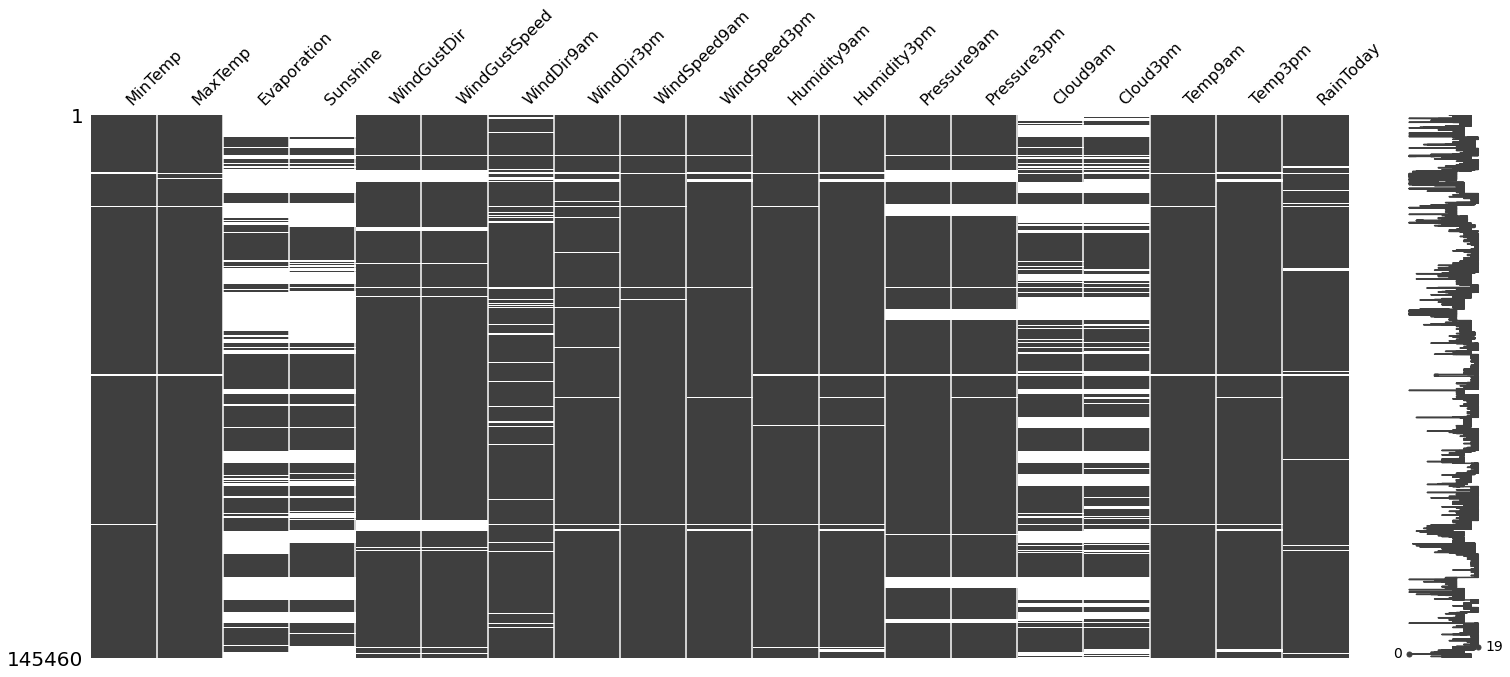

In [7]:
import missingno as msno
msno.matrix(df)

# Let's impute the missing data and encode the categorical features

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## For the categorical features, we will impute the missing values with the mode of the column and encode them with One-Hot encoding

In [9]:
categorical_pipeline = Pipeline(
    steps = [
        ("impute", SimpleImputer(strategy='most_frequent')),
        ("oh-encode", OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)

# For the numeric features, let's impute with the mean and scale with StandardScaler so that the features have 0 mean and a variance of 1

In [10]:
numeric_pipeline = Pipeline(
    steps = [
        ("impute", IterativeImputer(initial_strategy='mean')),
        ("scale", StandardScaler())
    ]
)

In [11]:
# Let's separate feature columns from the target column
X = df.drop(columns=['RainToday'], axis=1)
y = df.RainToday

In [12]:
# Get the lists of categorical and numerical columns
cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

In [13]:
cat_cols

Index(['WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [14]:
num_cols

Index(['MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm'],
      dtype='object')

# We will now transform our dataset with the help of pipelines
# that we defined earlier

In [15]:
from sklearn.compose import ColumnTransformer

In [16]:
process = ColumnTransformer(
    transformers = [
        ("categorical", categorical_pipeline, cat_cols),
        ("numeric", numeric_pipeline, num_cols)
    ]
)

In [17]:
X_processed = process.fit_transform(X)
y_processed = SimpleImputer(strategy="most_frequent").fit_transform(
              y.values.reshape(-1,1))

/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# Split the train, test data in default 3:1 ratio

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed
)

# All is set now! We just need to add the classifier.

In [20]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier()

In [21]:
xgb_cl.fit(X_train, y_train)
preds = xgb_cl.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
from sklearn.metrics import accuracy_score

In [23]:
accuracy_score(y_test, preds)

0.8421834181218204

In [25]:
xgb_cl.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1}

# Let's tune the model

In [51]:
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.05],
    "gamma": [0, 0.5, 1],
    "reg_lambda": [1, 3],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5, 1],
}

In [52]:
from sklearn.model_selection import GridSearchCV

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(X_processed, y_processed.ravel())

# Print the best parameters
print(grid_cv.best_score_, grid_cv.best_params_)

0.8608368319426437 {'colsample_bytree': 1, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 3, 'scale_pos_weight': 3, 'subsample': 0.8}


In [43]:
best_params = {'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.1, 
                    'max_depth': 7, 'reg_lambda': 10, 'scale_pos_weight': 3, 
                    'subsample': 0.8}


In [53]:
final_cl = xgb.XGBClassifier(
    **grid_cv.best_params_,
    objective="binary:logistic"
)

In [54]:
final_cl.fit(X_train, y_train.ravel())
preds = final_cl.predict(X_test)
accuracy_score(y_test.ravel(), preds)

0.8174618451808057